In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import mpmath as mpm
from scipy.optimize import curve_fit
import matplotlib as mpl
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

from matplotlib.ticker import StrMethodFormatter
import time
start_total = time.time()

In [2]:
from plasma_jet_class_disc import sieplasmadisc

In [3]:
import os
my_path = '/home/tomi/Documentos/Fisica/Tesis/escrito-tesis/images/'

In [4]:
zl = 0.2; zs = 1.2
Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
c_light = (const.c).to(u.cm/u.second)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
y0 = 1.0*u.kpc
z0 = 1.*u.kpc
#r0 = 0.1*u.kpc
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')
theta_E_num = theta_E_SIS()
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [5]:
eta = 0.15
pi = np.pi
n0 = 40./(u.cm)**(3)
alpha = 0.*np.pi/180.

In [6]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  3.1455687125523886 minutes


In [7]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [8]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [9]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [10]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [11]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:52: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:53: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) - np.sqrt(Delta))


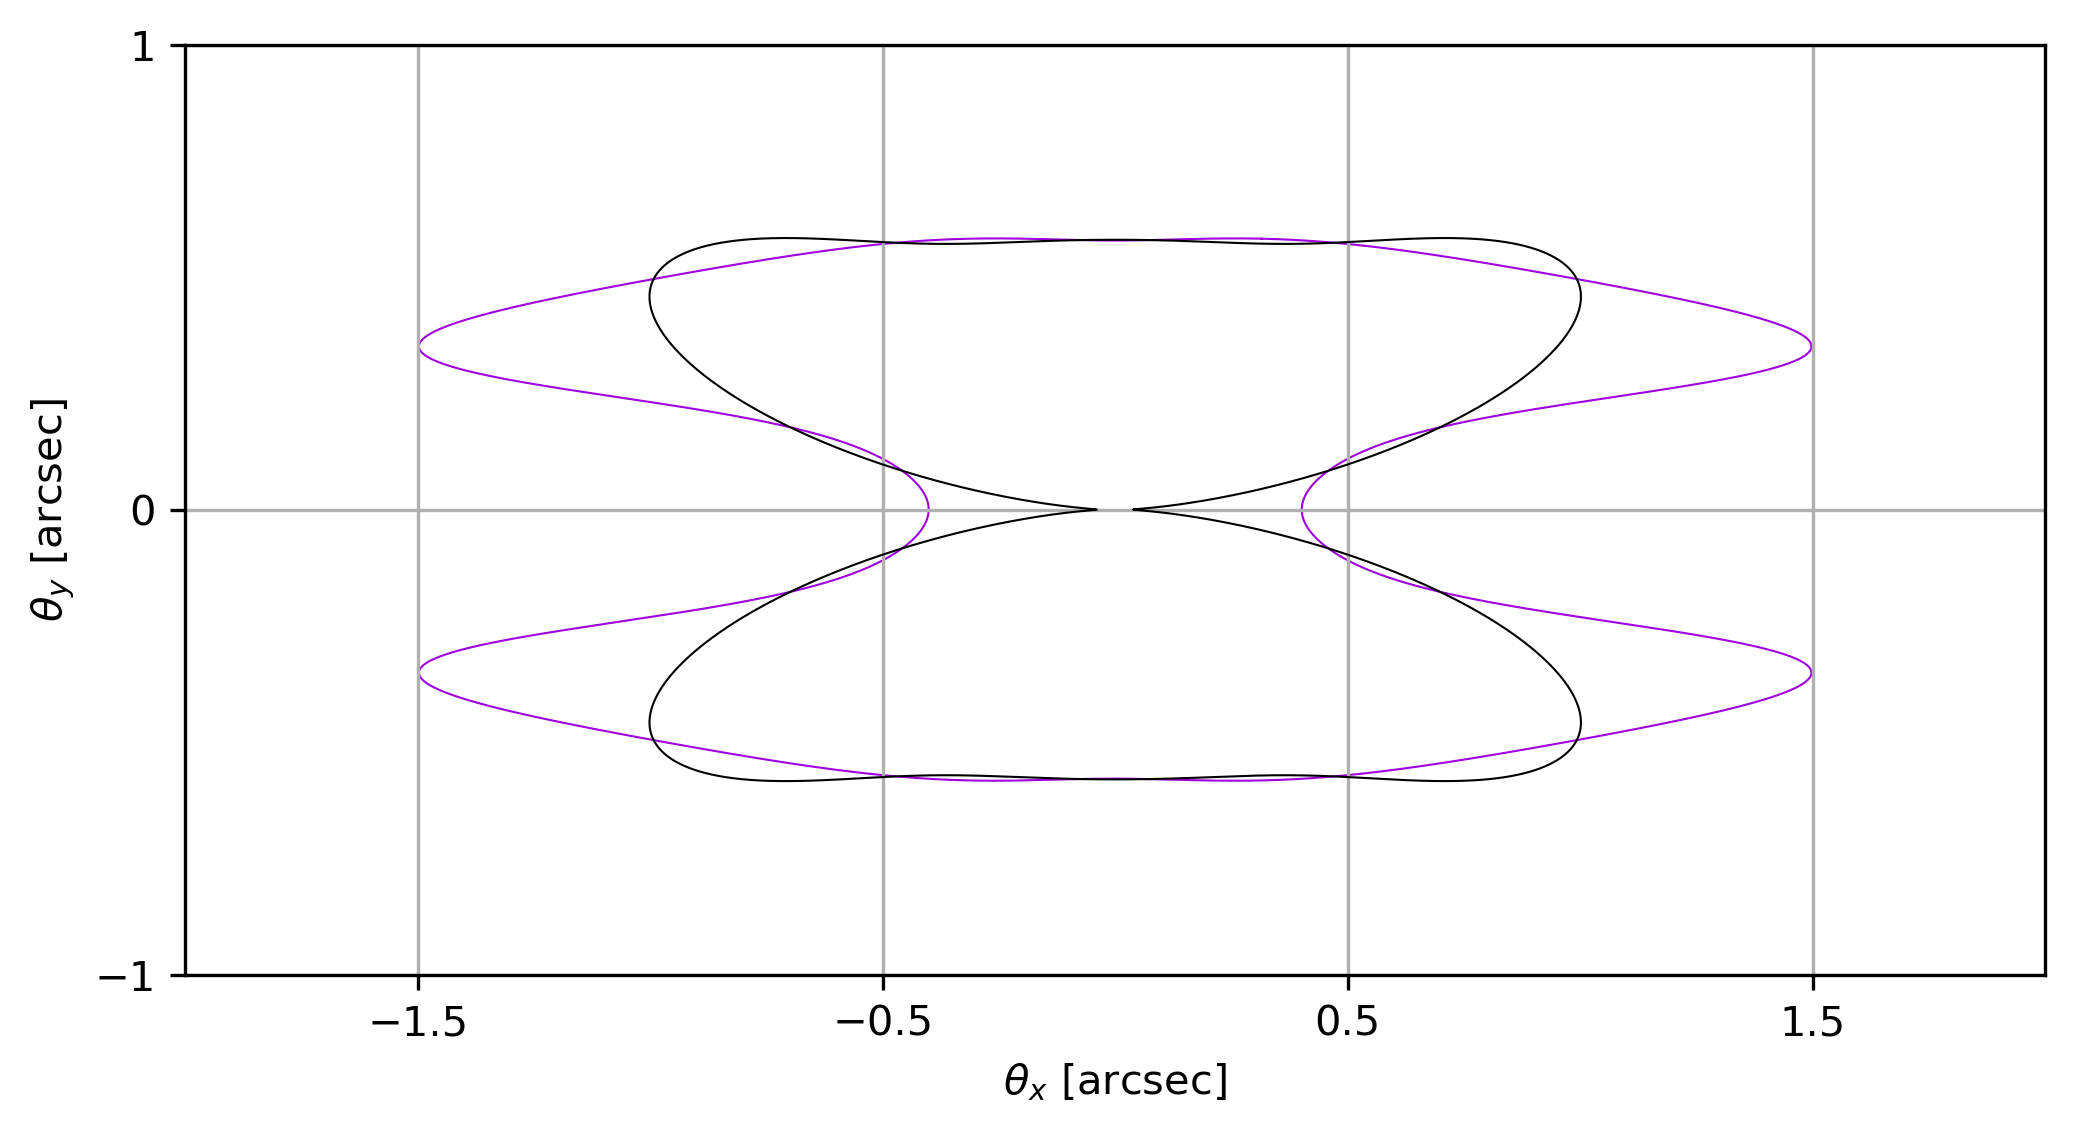

In [12]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
                 
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image81.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [13]:
eta = 0.15
pi = np.pi
n0 = 40./(u.cm)**(3)
alpha = 5.*np.pi/180.

In [14]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  5.409280145168305 minutes


In [15]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [16]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [17]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [18]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [19]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:52: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:53: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) - np.sqrt(Delta))


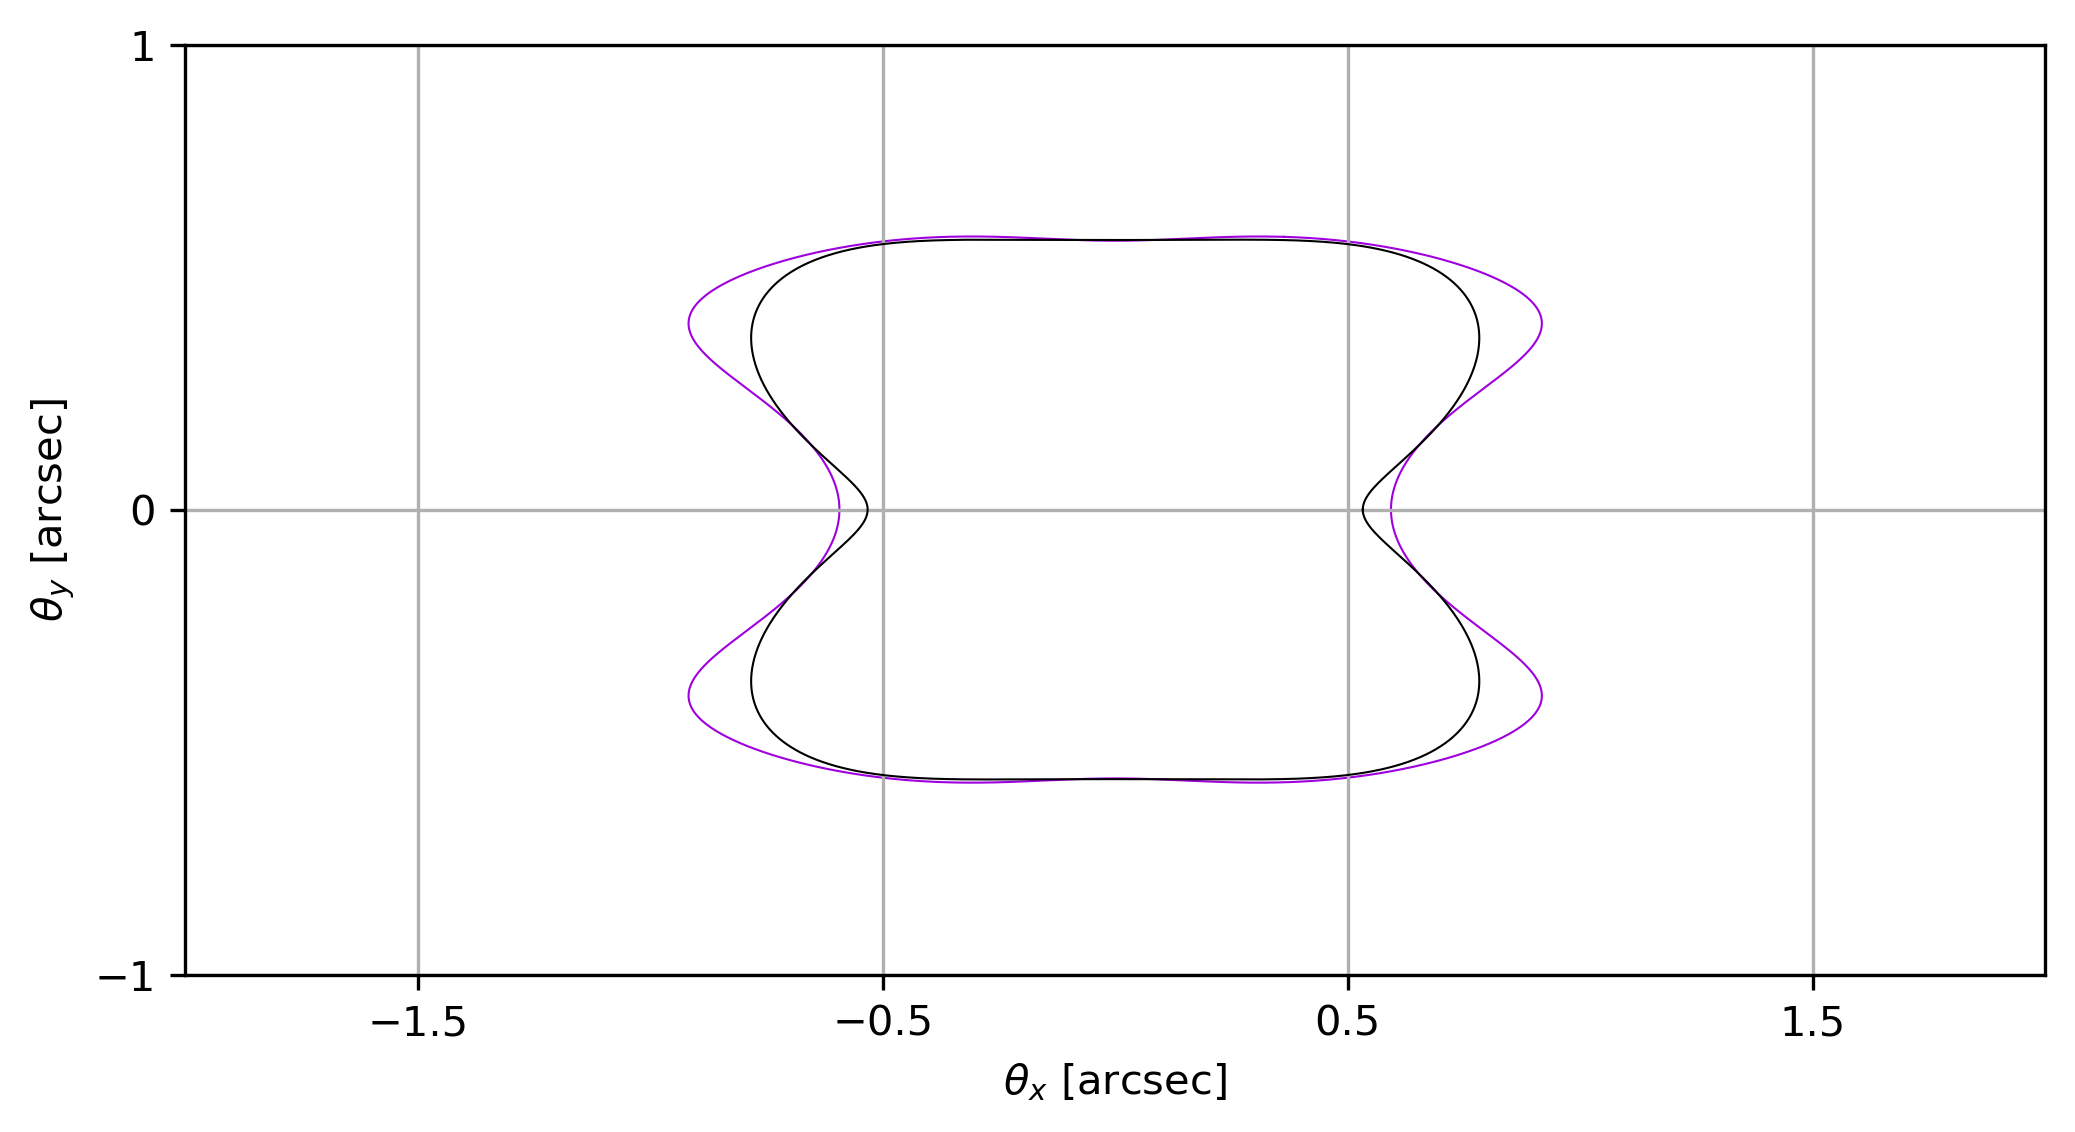

In [20]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
    
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image82.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [21]:
eta = 0.15
pi = np.pi
n0 = 40./(u.cm)**(3)
alpha = 10.*np.pi/180.

In [22]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  5.460522862275441 minutes


In [23]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [24]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [25]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [26]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [27]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:52: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:53: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) - np.sqrt(Delta))


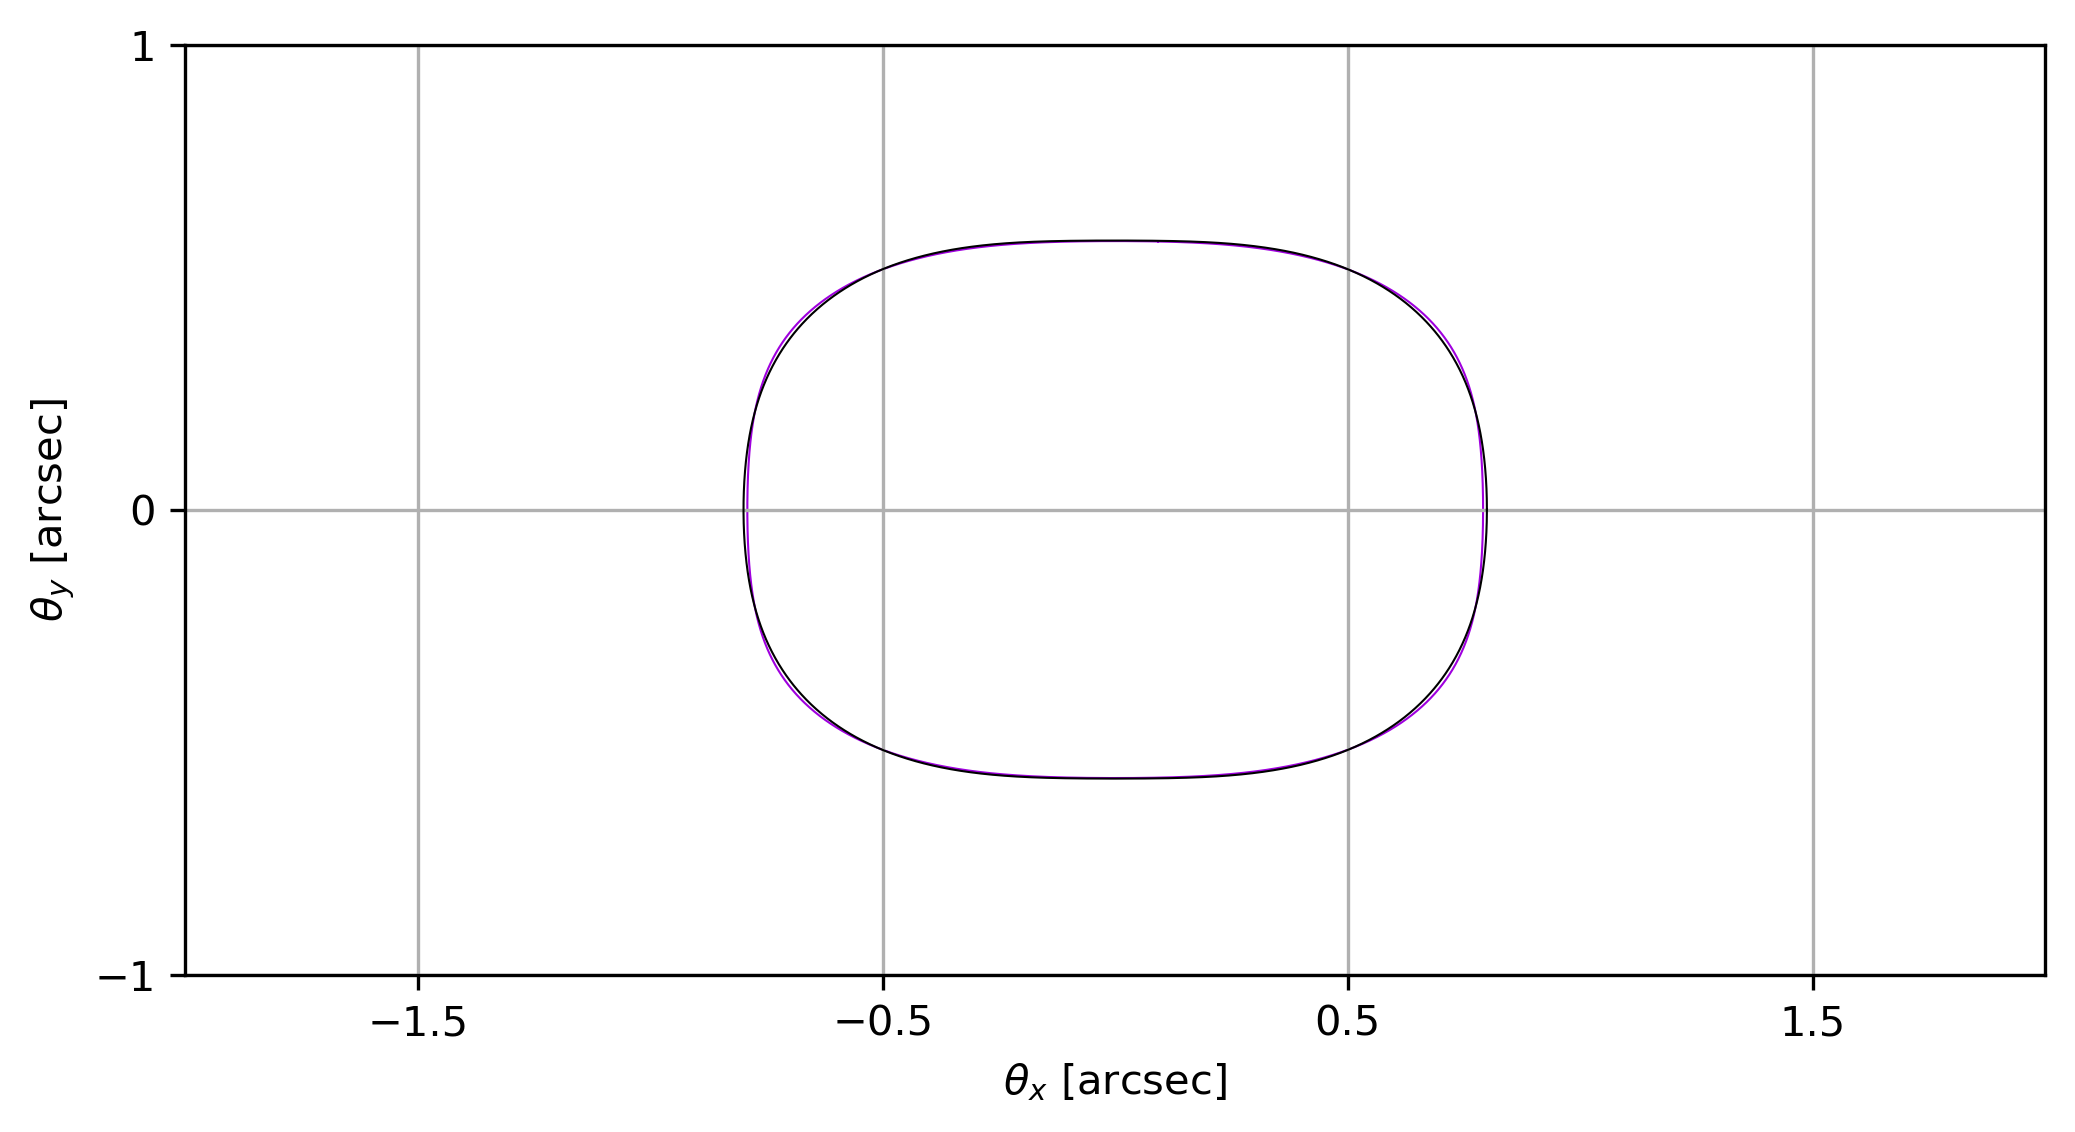

In [28]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
    
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image83.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [29]:
eta = 0.15
pi = np.pi
n0 = 40./(u.cm)**(3)
alpha = 7.*np.pi/180.

In [30]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  5.7152357737223305 minutes


In [31]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [32]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [33]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [34]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [35]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:52: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:53: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) - np.sqrt(Delta))


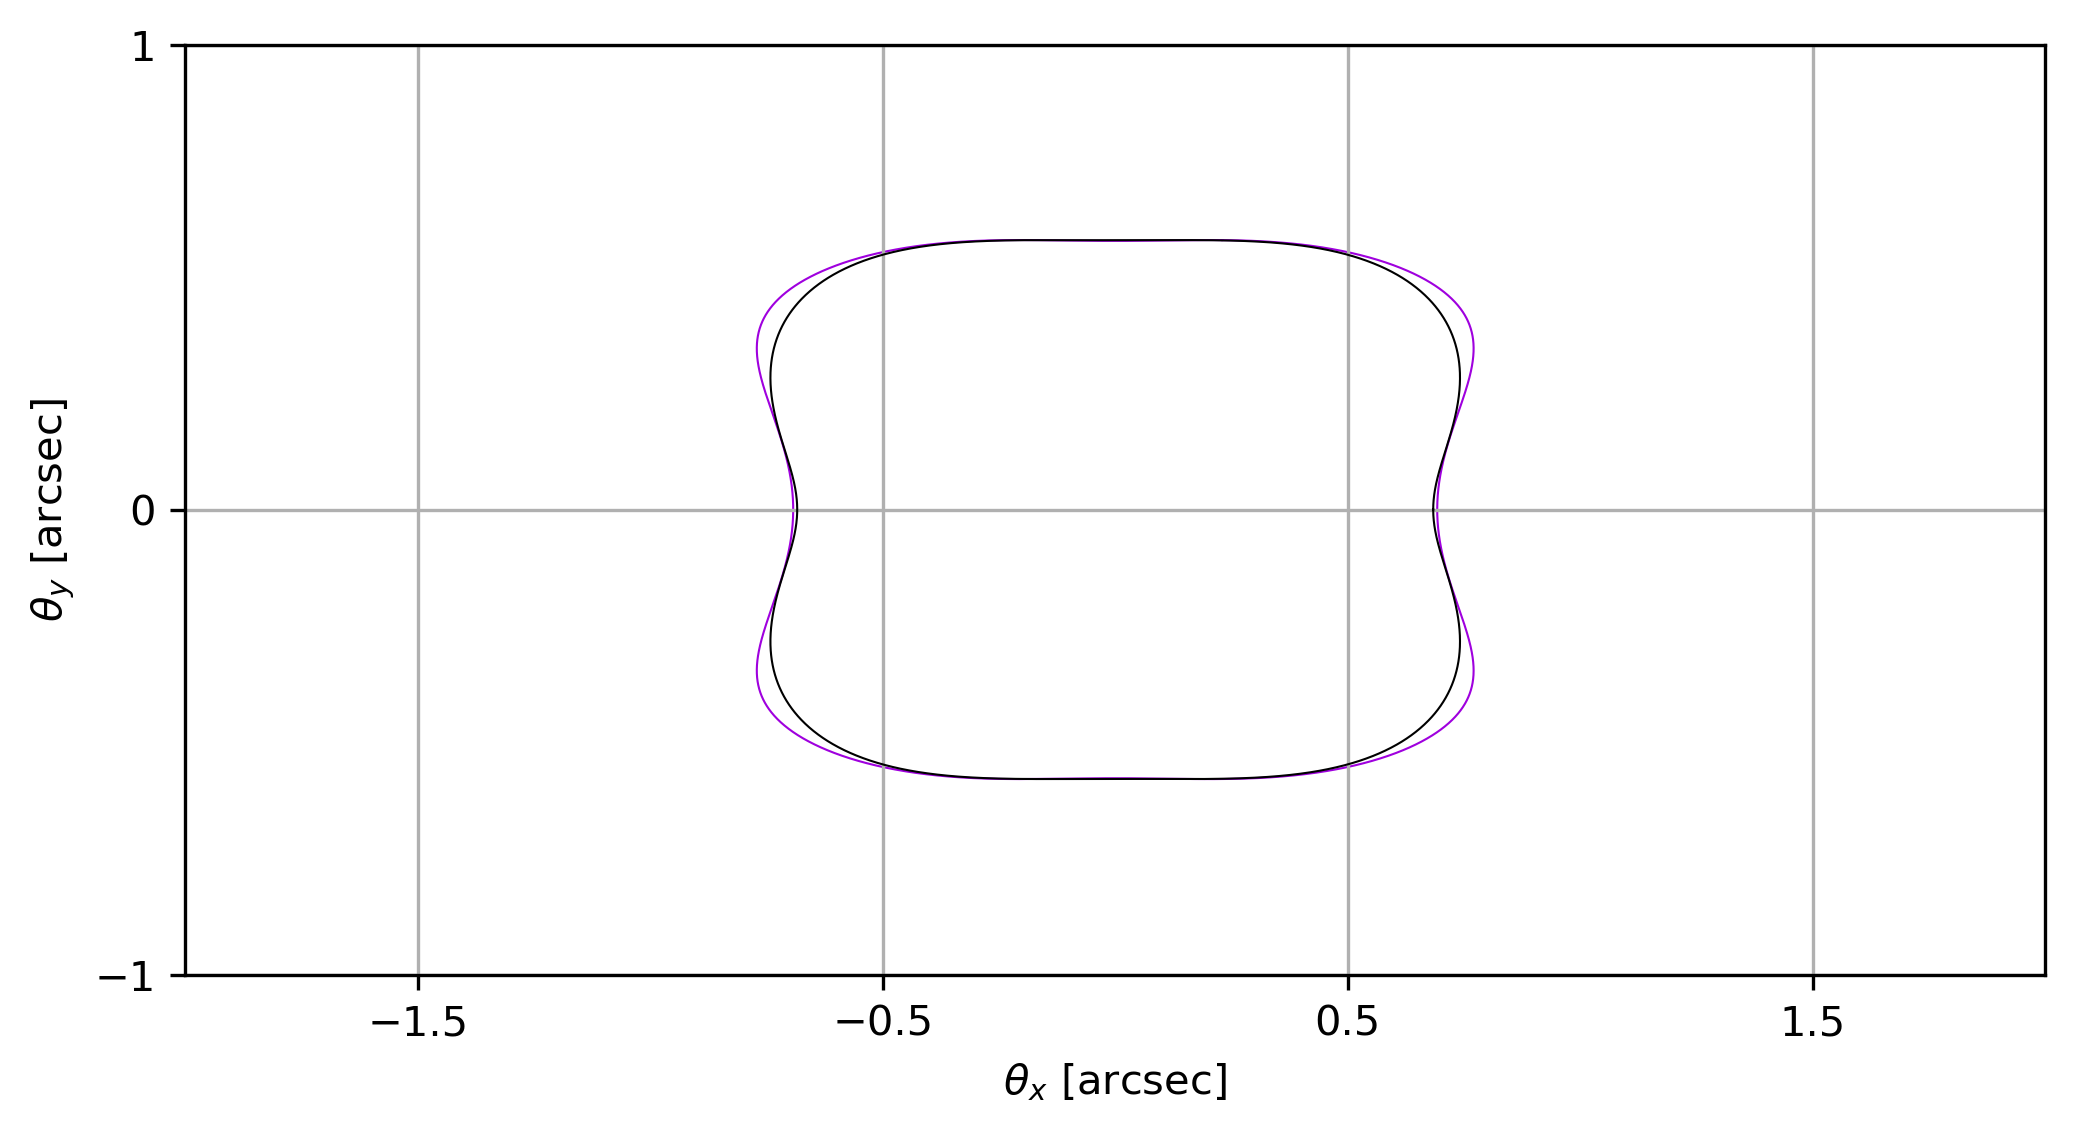

In [36]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
    
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image84.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

## Pongamos un plasma más fuerte

In [37]:
eta = 0.15
pi = np.pi
n0 = 300./(u.cm)**(3)
alpha = 30.*np.pi/180.

In [38]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  5.9761509935061135 minutes


In [39]:
nu = 50.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [40]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [41]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [42]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [43]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

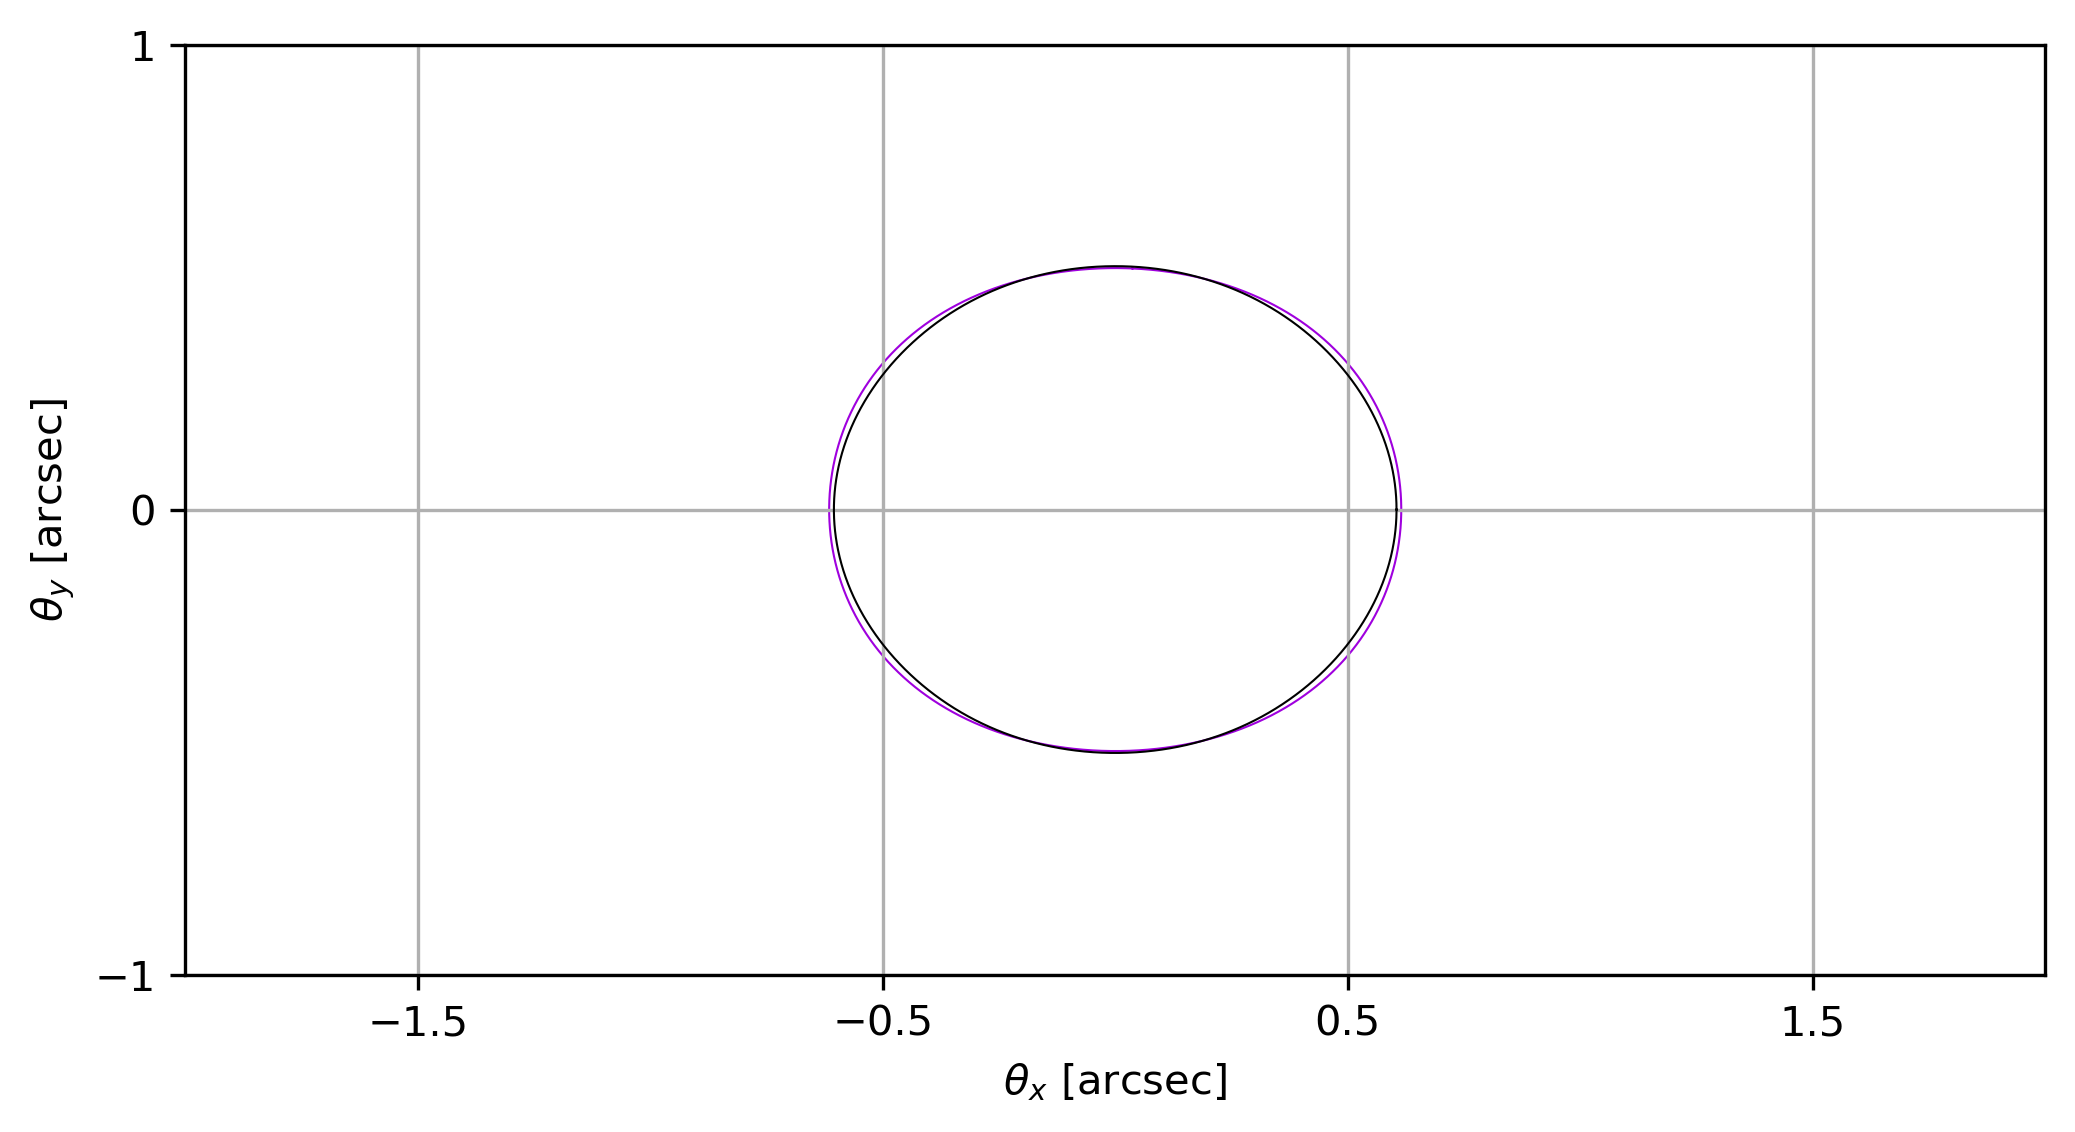

In [44]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
    
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image85.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [45]:
eta = 0.15
pi = np.pi
n0 = 300./(u.cm)**(3)
alpha = 25.*np.pi/180.

In [46]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  5.817193500200907 minutes


In [47]:
nu = 50.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [48]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [49]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [50]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [51]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:52: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:53: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) - np.sqrt(Delta))


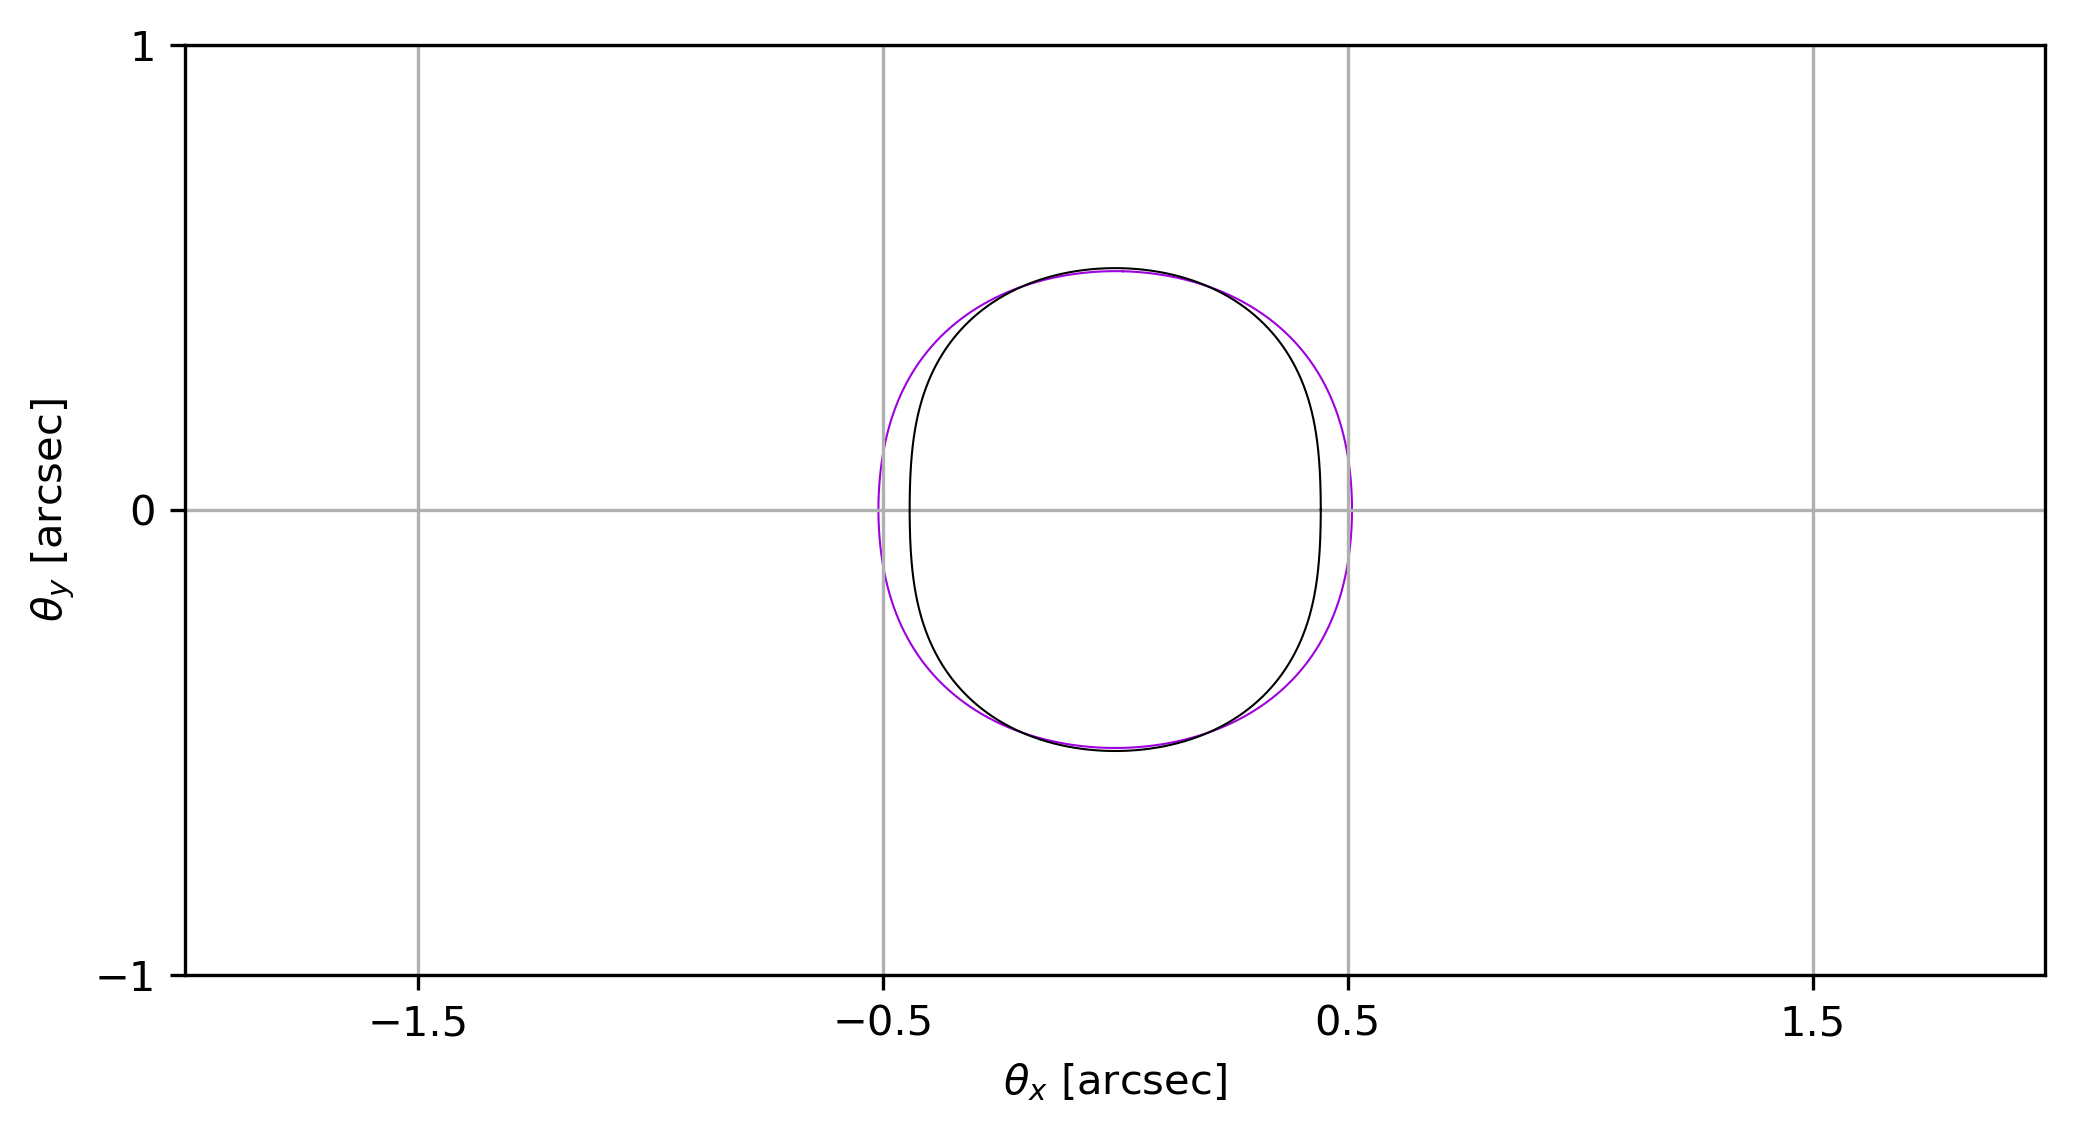

In [52]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
    
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image86.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [53]:
eta = 0.15
pi = np.pi
n0 = 300./(u.cm)**(3)
alpha = 20.*np.pi/180.

In [54]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


time:  5.576082595189413 minutes


In [55]:
nu = 50.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [56]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':eta, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [57]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

curve_e = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [58]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0r = r0/Dl):  2.9240748137875747 arcsec
Angular scale radius (theta_0y = y0/Dl):  0.29240748137875755 arcsec


In [59]:
phi = np.linspace(0,2*np.pi, 3000)
a = np.cos(alpha)**2/r0**2 + np.sin(alpha)**2/y0**2 
psi0_plasma = (Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*np.sqrt(np.pi/a) \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmadisc(theta_E_g, eta, phi, psi0_plasma_num, theta_0r, theta_0y, alpha, delta_rs, deltab_10, deltab_20)

theta_E = sie_plasma.theta_E

critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:52: RuntimeWarning: invalid value encountered in sqrt
  delta_r_1 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) + np.sqrt(Delta))
/home/tomi/Documentos/Fisica/Tesis/lens-grav/perturbative/plasma_jet_class_disc.py:53: RuntimeWarning: invalid value encountered in sqrt
  delta_r_2 = 1/(1 - self.d2psi0_dr2 )*(self.ddpsi_dr + deltab_10*np.cos(phi) + deltab_20*np.sin(phi) - np.sqrt(Delta))


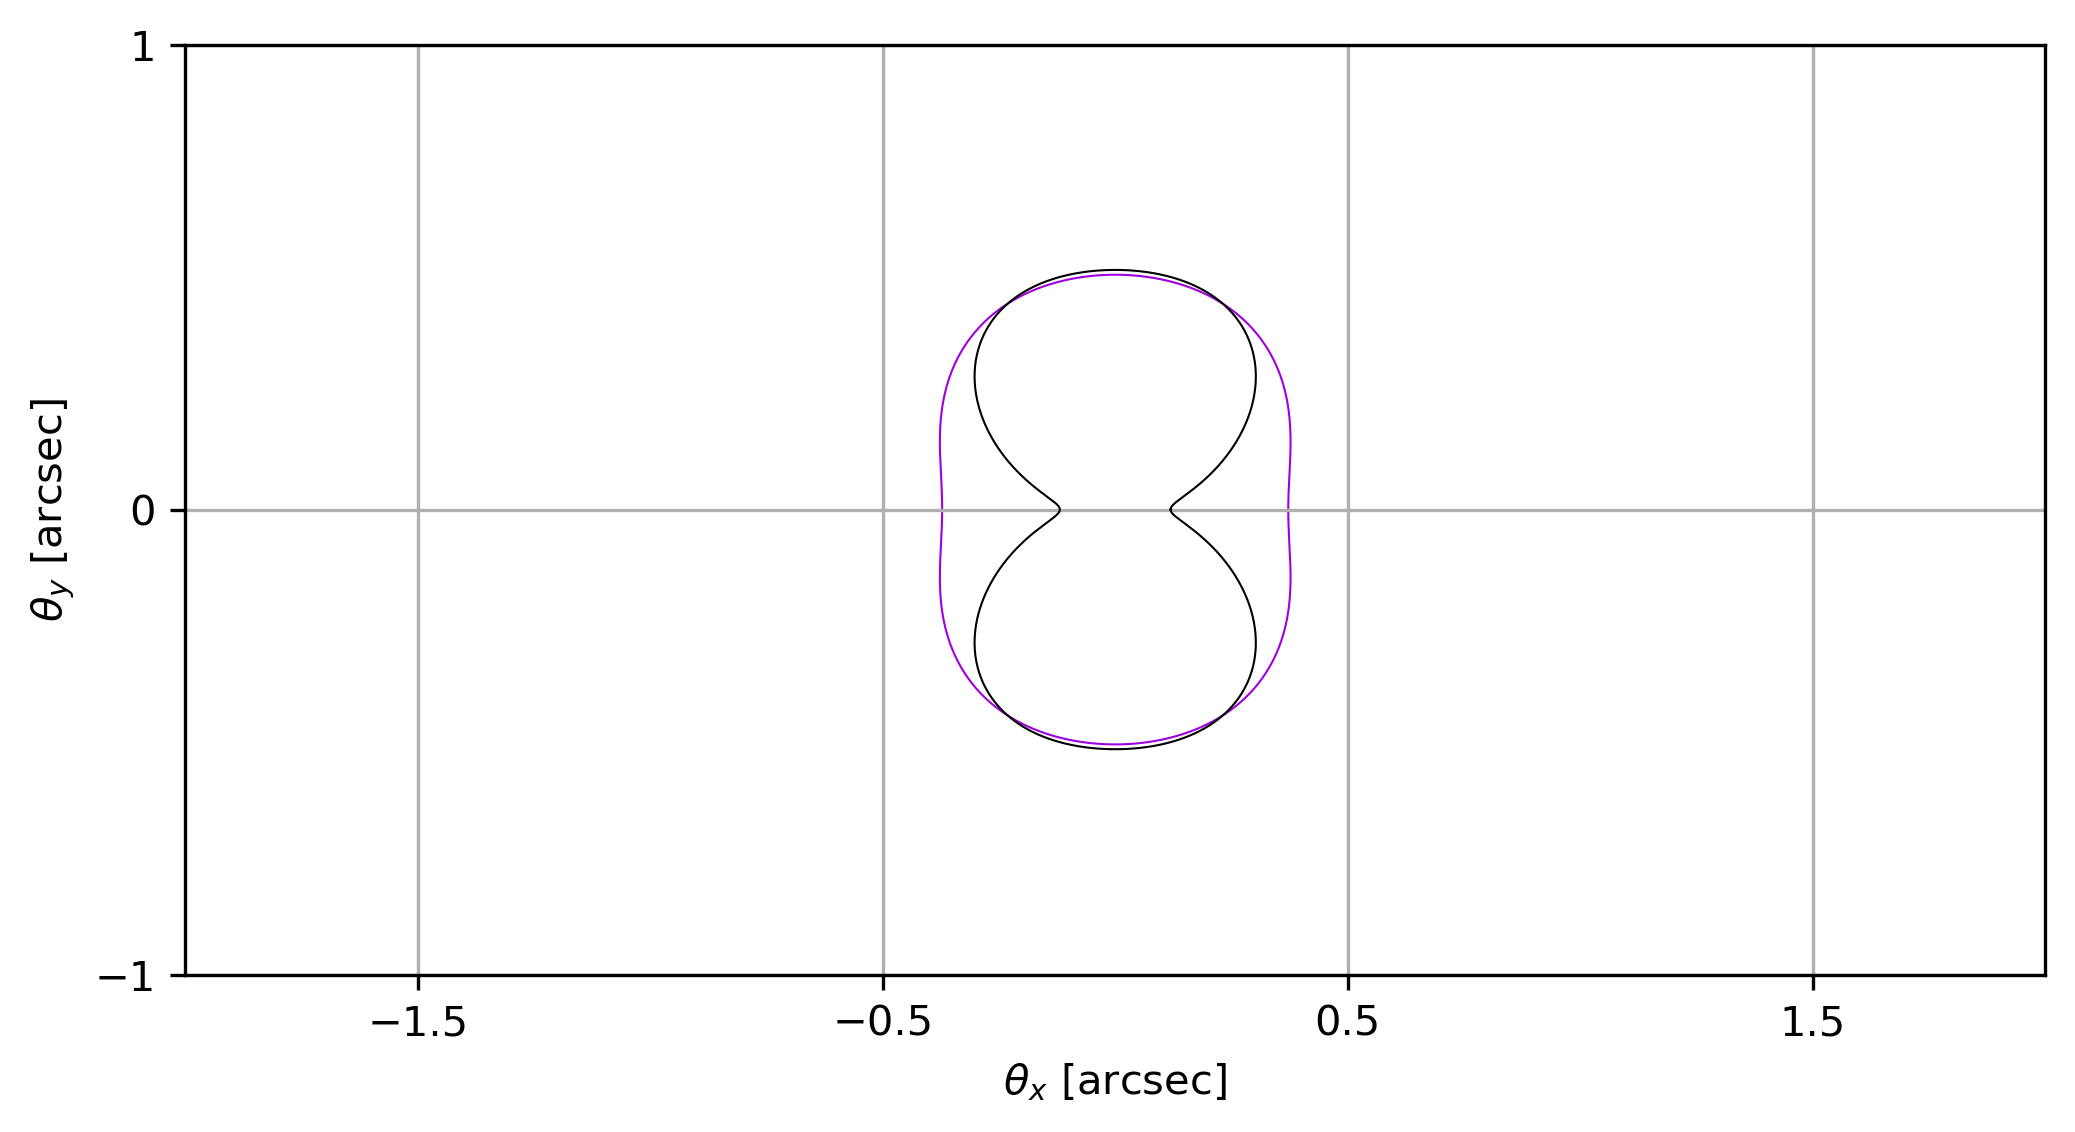

In [60]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca()
                 
ax.set_xlim([-2, 2])
ax.set_ylim([-1, 1])

ax.set_xticks(np.arange(-1.5, 2, 1))
ax.set_yticks(np.arange(-1, 1.5, 1))

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = 'black', lw = .5)
# plt.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)
plt.plot(curve_e[0][0],curve_e[1][0], color = '#9f00de',lw = .5, zorder=1)
# plt.plot(curve_e[2][0],curve_e[3][0], color = '#ff5900',lw = .7, zorder=1)
    
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
fig.savefig(my_path + 'image87.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [61]:
end_total = time.time()
print('total time: ',(end_total-start_total)/60.,' minutes')

total time:  41.78866638739904  minutes
